In [52]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

## timeseries package
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import scipy.stats as scs
import statsmodels.api as sm
from datetime import timedelta
import warnings
import seaborn as sns
from numpy import log
from sklearn.metrics import mean_squared_error

In [2]:
raw_data = pd.read_excel("Prices.xlsx",  sheet_name = 'Daily', header = 8, names= ['Date','Price'],index_col=0, usecols= "D:E", parse_dates=True)
raw_data.head(10)



,Price
Date,
1978-12-29,226.00
1979-01-01,226.00
1979-01-02,226.80
1979-01-03,218.60
1979-01-04,223.15
1979-01-05,225.50
1979-01-08,223.10
1979-01-09,224.00
1979-01-10,220.70


In [32]:
df_gold= raw_data.loc['2010':'2022']
df = pd.DataFrame(df_gold['Price'])
df = df.resample('M').last()
df


,Price
Date,
2010-01-31,1078.50
2010-02-28,1108.25
2010-03-31,1115.50
2010-04-30,1179.25
2010-05-31,1207.50
...,...
2021-09-30,1742.80
2021-10-31,1769.15
2021-11-30,1804.40


In [33]:
df.isnull().any()


Price    False
dtype: bool

Giá vàng đã tăng như thế nào trong hơn một thập kỷ?

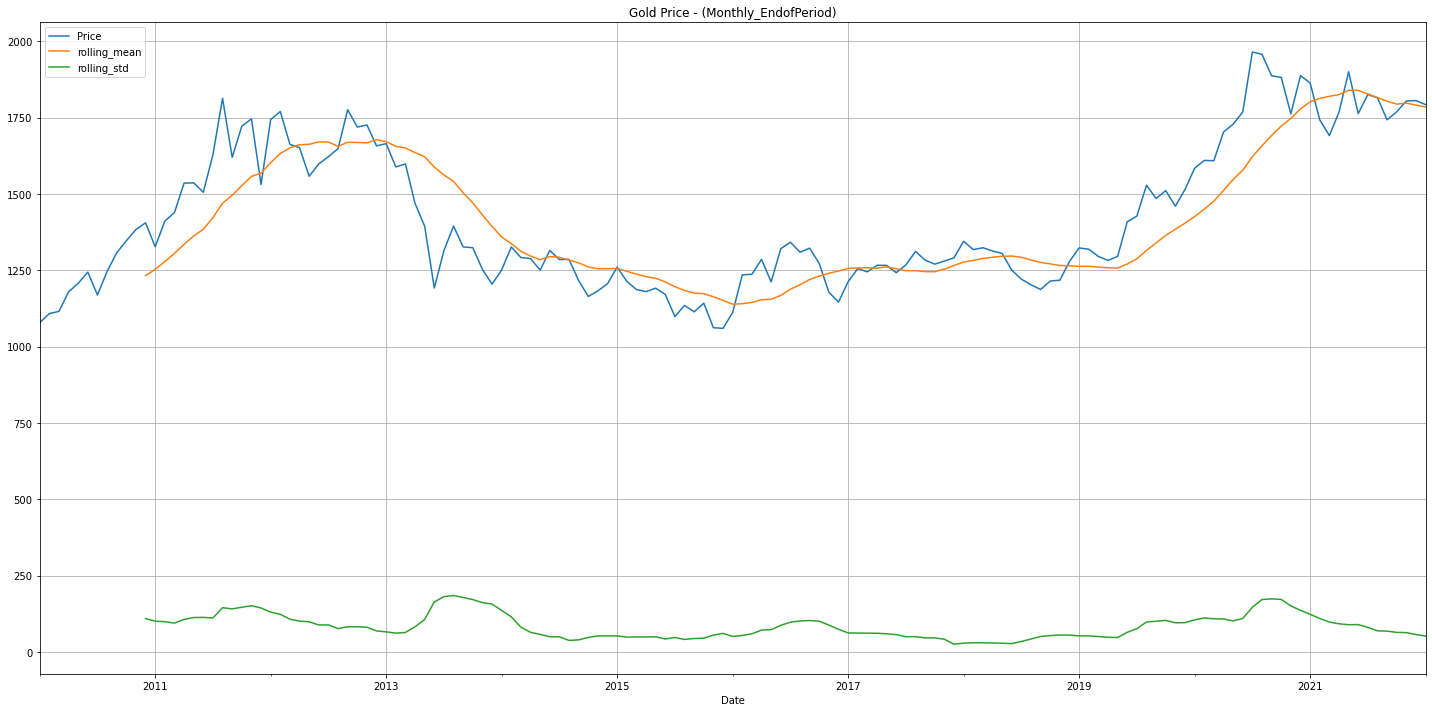

In [34]:

WINDOW_SIZE = 12
df['rolling_mean'] = df.Price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.Price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price - (Monthly_EndofPeriod)')
plt.tight_layout()
plt.grid(True)
plt.tight_layout()
plt.show()

# PHÂN RÃ DỮ LIỆU

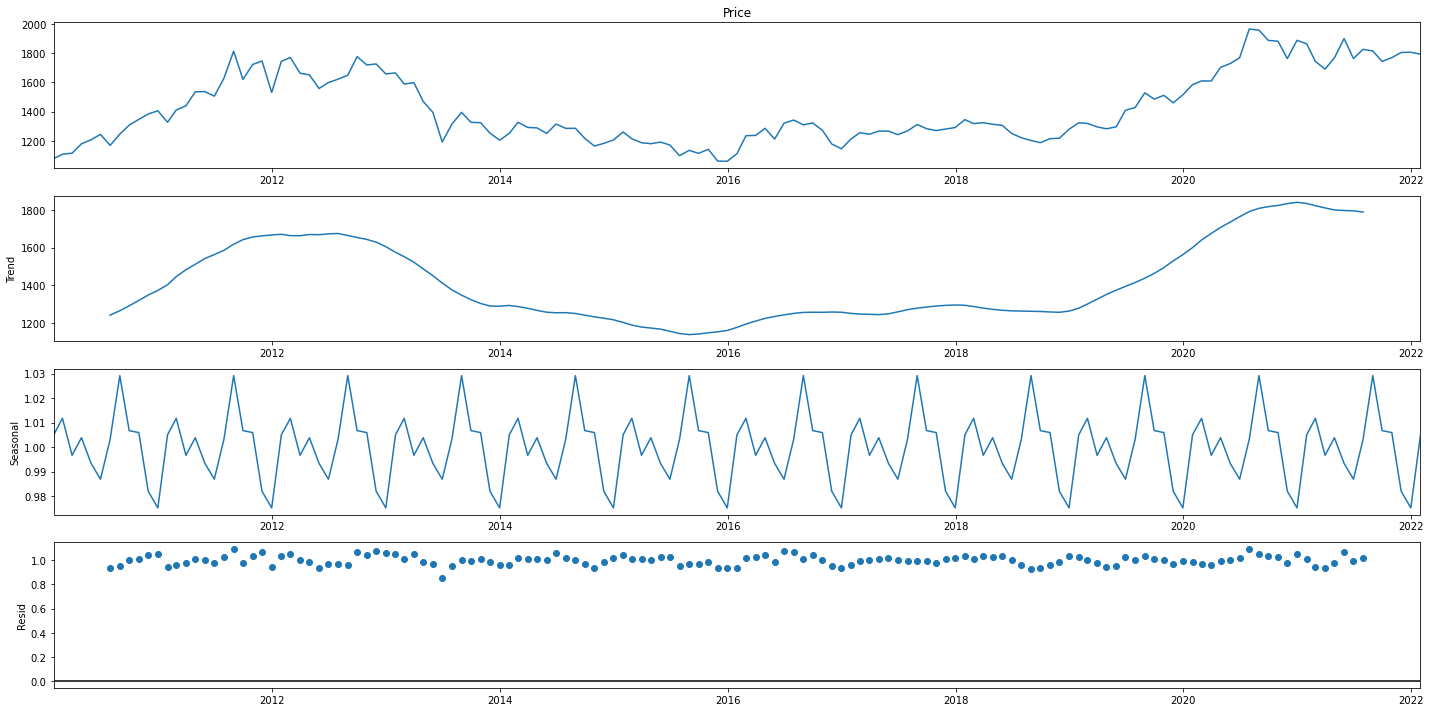

In [35]:
plt.rcParams['figure.figsize'] = (20, 10)
decompose_results = seasonal_decompose(df['Price'],model='multiplicative')
decompose_results.plot()

plt.show()

Giá Vàng hiện tại đang có xu hướng giảm

Dựa vào biểu đồ Seasonal, có thể thấy giá vàng có tính mùa vụ, mô hình lặp lại hàng năm khá rõ ràng
=> Dữ liệu giá vàng không cố định 


## KIỂM ĐỊNH TÍNH DỪNG CỦA DỮ LIỆU

In [36]:
#tạo function adf_test
def stationary_test(a):

    stas_index = ['Test Statistic', 'P-value', 'Numbers of Lags Used', 'Numbers of Observations Used']

    test_adf = adfuller(a, autolag='AIC')
    results = pd.Series(test_adf[0:4], index = stas_index)

    for key, value in test_adf[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [37]:
# kiểm tra với gold price
stationary_test(df['Price'])

Test Statistic                   -1.449950
P-value                           0.558109
Numbers of Lags Used              1.000000
Numbers of Observations Used    143.000000
Critical Value (1%)              -3.476927
Critical Value (5%)              -2.881973
Critical Value (10%)             -2.577665
dtype: float64

### P-value = 0.558109 > 5% => dữ liệu giá không có tính dừng
### => Cần sai phân bậc 1 cho dữ liệu để cải thiện

In [38]:
df['diff'] = df['Price'].diff(1)
df

,Price,rolling_mean,rolling_std,diff
Date,,,,
2010-01-31,1078.50,NaN,NaN,NaN
2010-02-28,1108.25,NaN,NaN,29.75
2010-03-31,1115.50,NaN,NaN,7.25
2010-04-30,1179.25,NaN,NaN,63.75
2010-05-31,1207.50,NaN,NaN,28.25
...,...,...,...,...
2021-09-30,1742.80,1803.654167,68.338720,-72.05
2021-10-31,1769.15,1794.262500,64.236421,26.35
2021-11-30,1804.40,1797.750000,63.489892,35.25


In [40]:
df.dropna(inplace=True)
df

,Price,rolling_mean,rolling_std,diff
Date,,,,
2010-12-31,1405.50,1232.562500,109.537723,22.00
2011-01-31,1327.00,1253.270833,100.914368,-78.50
2011-02-28,1411.00,1278.500000,99.192249,84.00
2011-03-31,1439.00,1305.458333,94.724651,28.00
2011-04-30,1535.50,1335.145833,106.649301,96.50
...,...,...,...,...
2021-09-30,1742.80,1803.654167,68.338720,-72.05
2021-10-31,1769.15,1794.262500,64.236421,26.35
2021-11-30,1804.40,1797.750000,63.489892,35.25


In [46]:
stationary_test(df['diff'])

Test Statistic                 -1.335122e+01
P-value                         5.663501e-25
Numbers of Lags Used            0.000000e+00
Numbers of Observations Used    1.330000e+02
Critical Value (1%)            -3.480500e+00
Critical Value (5%)            -2.883528e+00
Critical Value (10%)           -2.578496e+00
dtype: float64

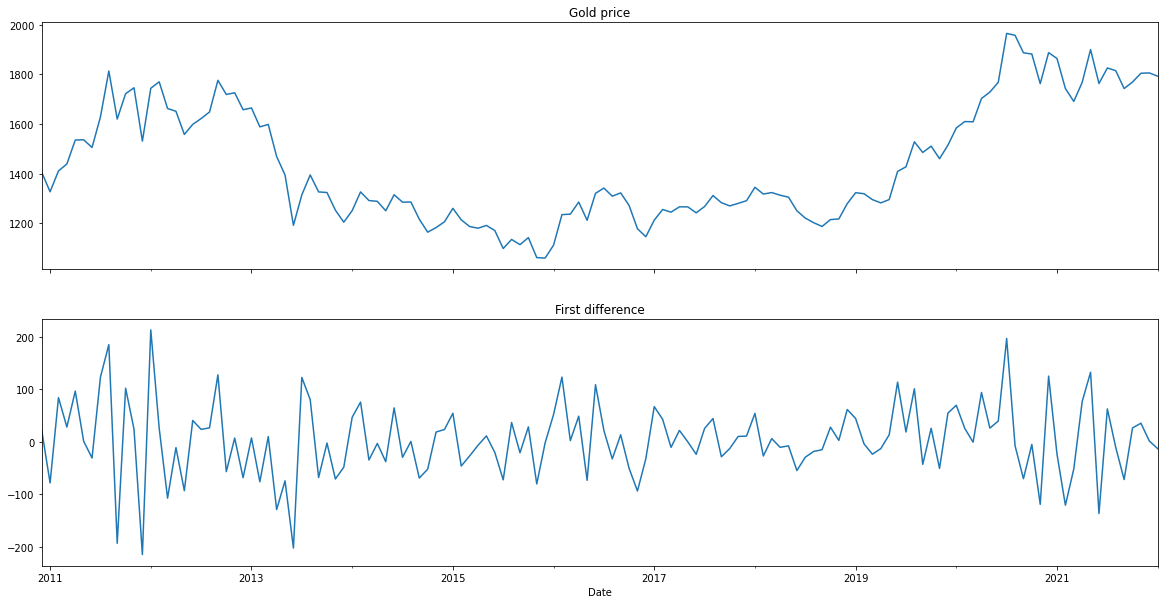

In [45]:
#  Vẽ biểu đồ giá vàng và sai phân bậc 1 của nó 
fig, ax = plt.subplots(2, sharex = True)
df['Price'].plot(ax = ax[0], title = 'Gold price')
df['diff'].plot(ax = ax[1], title = 'First difference')

plt.show()

P-value sau khi sai phân bậc 1 <5% => dữ liệu đã có tính dừng.
###  Do đó, chúng ta có thể kết luận rằng tham số “d” là 1

***Autocorrelation test***

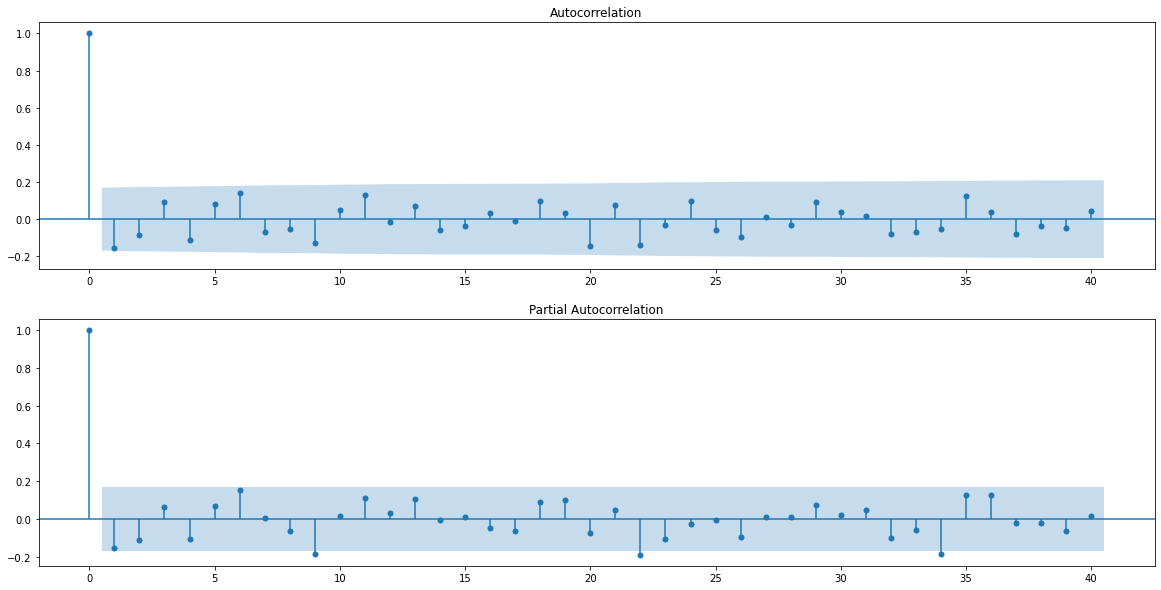

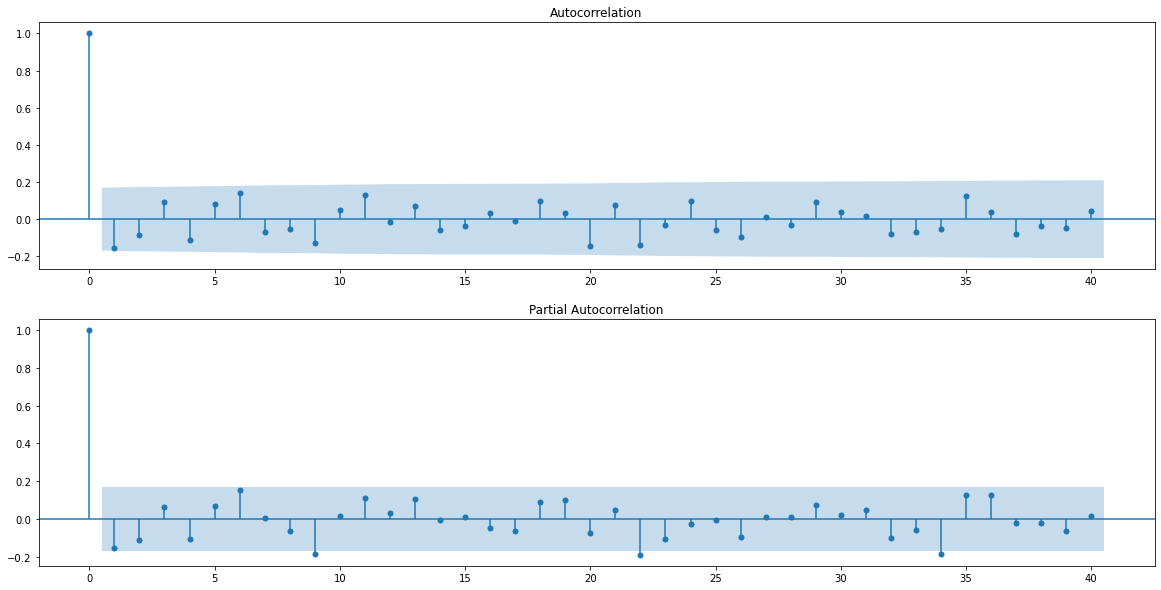

In [47]:
fig,ax=plt.subplots(2,figsize=(20,10))
plot_acf(df['diff'],ax=ax[0],lags=40,alpha=0.05)
plot_pacf(df['diff'],ax=ax[1],lags=40,alpha=0.05)




## ARIMA MODEL

In [48]:
df= df.dropna()

arima = sm.tsa.arima.ARIMA(df.Price, order = (0, 1, 0)).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  134
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -756.669
Date:                Tue, 25 Jan 2022   AIC                           1515.339
Time:                        22:53:19   BIC                           1518.229
Sample:                    12-31-2010   HQIC                          1516.513
                         - 01-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5118.4615    506.213     10.111      0.000    4126.302    6110.621
Ljung-Box (L1) (Q):                   3.08   Jarque-Bera (JB):                 6.54
Prob(Q):                              0.08   Pr

In [53]:
auto_arima = pm.auto_arima(df['Price'], trace = 1, 
                           error_action = 'ignore',
                           suppress_warnings = True,
                           seasonal = False,
                           stepwise = True,
                           approximation = False,
                           n_jobs = -1,
                           seasonal_test = False)

C:\Users\ASUS\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1517.338, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1517.118, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1516.030, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1515.382, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1515.339, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1517.059, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.617 seconds


In [54]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -756.669
Date:                Tue, 25 Jan 2022   AIC                           1515.339
Time:                        22:58:36   BIC                           1518.229
Sample:                             0   HQIC                          1516.513
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5118.4615    506.213     10.111      0.000    4126.302    6110.621
Ljung-Box (L1) (Q):                   3.08   Jarque-Bera (JB):                 6.54
Prob(Q):                              0.08   Pr

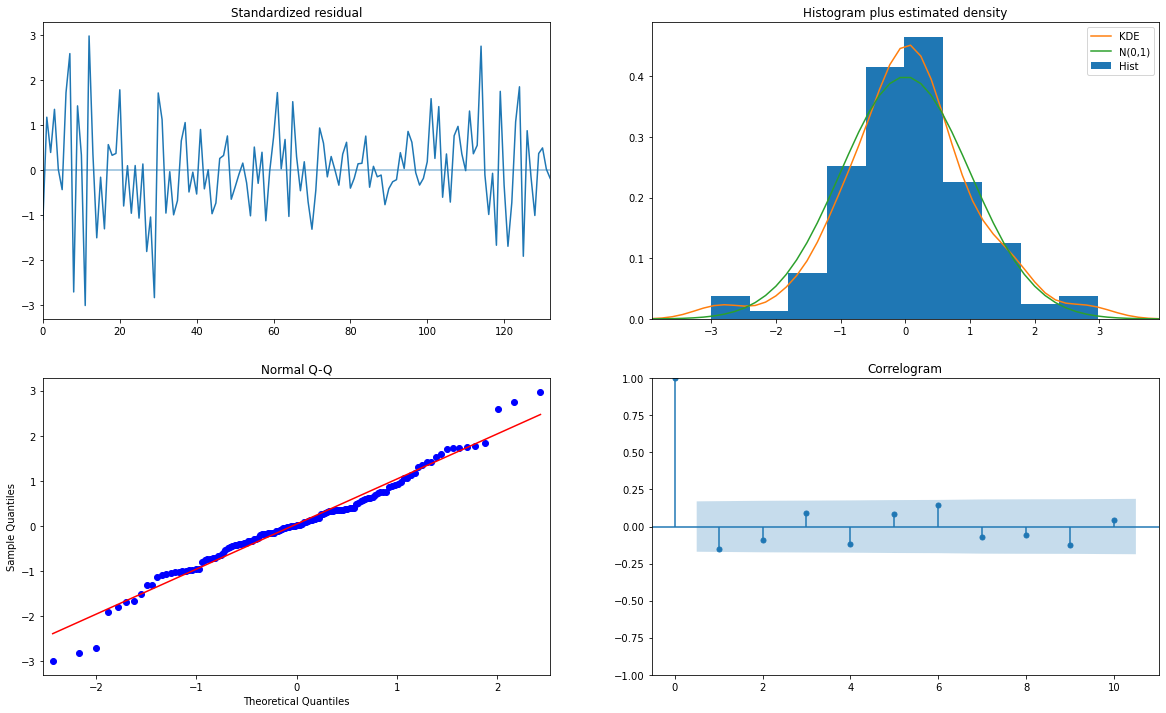

In [56]:
auto_arima.plot_diagnostics(figsize=(20, 12))
plt.show()

In [57]:
# Create Training and Test
train = df['Price'][:'2020-11-30']
test = df['Price']['2020-11-30':]

print(train.shape, test.shape)

(120,) (15,)


In [63]:
test

Date
2020-11-30    1762.55
2020-12-31    1887.60
2021-01-31    1863.80
2021-02-28    1742.85
2021-03-31    1691.05
2021-04-30    1767.65
2021-05-31    1899.95
2021-06-30    1763.15
2021-07-31    1825.75
2021-08-31    1814.85
2021-09-30    1742.80
2021-10-31    1769.15
2021-11-30    1804.40
2021-12-31    1805.85
2022-01-31    1792.60
Freq: M, Name: Price, dtype: float64

In [78]:
# Build Model
model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit()  

# Forecast
fc,se,conf= fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [82]:
# Forecast length
n_forecasts = len(test)

# ARIMA forecast restults
arima_pred = arima.forecast(n_forecasts,freq='W')

# Concatenate forecast data
arima_pred = pd.DataFrame(arima_pred)
arima_pred.columns = ['Predict']

In [86]:
df_fc = pd.DataFrame({'Actual price': list(test),
                           'Prediction price': list(arima_pred.Predict)},
                           index= test.index)

In [87]:
df_fc

,Actual price,Prediction price
Date,,
2020-11-30,1762.55,1792.6
2020-12-31,1887.60,1792.6
2021-01-31,1863.80,1792.6
2021-02-28,1742.85,1792.6
2021-03-31,1691.05,1792.6
2021-04-30,1767.65,1792.6
2021-05-31,1899.95,1792.6
2021-06-30,1763.15,1792.6
2021-07-31,1825.75,1792.6


In [88]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

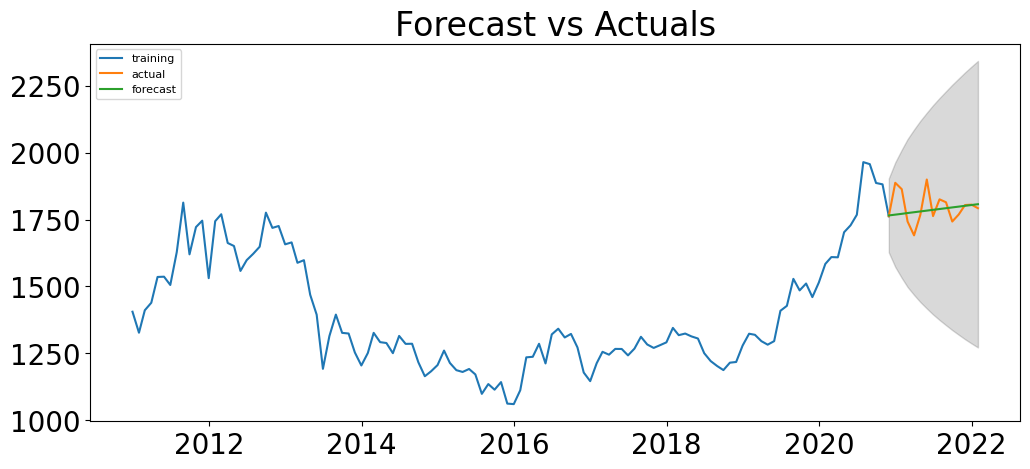

In [89]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [90]:
print(f"RMSE {mean_squared_error(test, fc, squared= False)}")

RMSE 58.38381348506672
